In [1]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import math
import seaborn as sns
from matplotlib import gridspec
import multiprocessing
import parmap
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
from sklearn.mixture import BayesianGaussianMixture as BGMM

In [2]:
plt.rcParams["font.family"] = "times new roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 75
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20 

from IPython.display import set_matplotlib_formats

In [3]:
%load_ext cython

# Functions

In [4]:
%%cython
cimport numpy as np
import numpy as np
import scipy as sp
import time
import os
import pickle
from numpy.random import uniform, normal, beta, exponential

def createDirectory(str path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print("Error: Failed to create the directory.")

# hyperparameters
D_min = 0.001
D_max = 2
unit_T = 0.1 # s
unit_L = 0.167 # um

########## functions for HMM

def hmm_p_ini(np.ndarray[np.double_t, ndim = 2] P, int nstates): ##P : transition probability, p_ij : prob. from j to i
    cdef np.ndarray[np.double_t, ndim = 2] p_ini
    cdef np.ndarray[np.double_t, ndim = 1] eig_val
    cdef np.ndarray[np.double_t, ndim = 2] eig_vec
    
    eig_val = np.real(np.linalg.eig(P)[0])
    eig_vec = np.real(np.linalg.eig(P)[1])
    p_ini = eig_vec[:, abs(eig_val - 1) < 0.0000001] / (eig_vec[:, abs(eig_val - 1) < 0.0000001]).sum()
    return p_ini #column vector

def logsumexpcol(np.ndarray[np.double_t, ndim = 2] x):
    cdef np.ndarray[np.double_t] y, z
    y = np.max(x, axis = 0)
    x = x - y
    z = y + np.log((np.exp(x)).sum(0))
    z[y[:]==-np.inf] = -np.inf
    return z

def log_space_product(np.ndarray[np.double_t, ndim = 2] A, np.ndarray[np.double_t, ndim = 2] B):
    Astack = np.stack([A]*A.shape[0]).transpose(2,1,0)
    Bstack = np.stack([B]*B.shape[1]).transpose(1,0,2)
    return sp.special.logsumexp(Astack+Bstack, axis=0)
    
def hmm_emission(np.ndarray[np.double_t, ndim = 1] obs,
                   np.ndarray[np.double_t, ndim = 2] sigma):
    return -np.log(2*np.pi*(sigma**2))/2 - (obs**2)/(2*(sigma**2))

def hmm_main(np.ndarray[np.double_t, ndim = 2] obs,   #obs : column vector, displacements
             np.ndarray[np.double_t, ndim = 2] P,
             np.ndarray[np.double_t, ndim = 2] sigma, #sigma : column vector
             int nstates):
    cdef np.ndarray[np.double_t, ndim = 2] pstate_ini, logPT, logpstatexprev, logpstatex  #pstate_ini : column vector
    cdef np.ndarray[np.double_t, ndim = 1] obs_cur # value
    cdef int i
    
    pstate_ini = hmm_p_ini(P, nstates).copy()
    logPT = np.log(P.T).copy()
    logpstatexprev = np.log(pstate_ini).copy()
    
    for i in range(obs.shape[0]):
        obs_cur = obs[i].copy()
        logpstatex = hmm_emission(obs_cur, sigma) + logpstatexprev
        logpstatexprev = logsumexpcol(logPT + logpstatex)[:, None]

    return logsumexpcol(logpstatex)  #log likelihood ?



########## functions for nested sampling
def prior_nonuniform(int nstates, int order):
    cdef np.ndarray[np.double_t, ndim = 2] alpha
    cdef int row, col
    
    if order < nstates:
        return uniform(D_min, D_max)
    else:
        alpha = np.ones((nstates, nstates)) * (1 + 0.5 / (nstates - 1))
        alpha[range(nstates), range(nstates)] = 10.5
        row = (int)((order - nstates) / nstates)
        col = order % nstates
        return beta(alpha[row, col], alpha[row + 1:, col].sum())       

def initial_stepsize(int nstates):
    cdef np.ndarray[np.double_t, ndim = 1] stepsize
    
    stepsize = np.zeros(nstates**2, dtype = float)
    if nstates == 1:
        stepsize[0] = np.sqrt(1/12) * (D_max - D_min) # step for diffusivity
    elif nstates == 2:
        stepsize[:2] = np.sqrt(1/12) * (D_max - D_min) # step for diffusivity
        stepsize[2:4] = np.sqrt(1/12)
    elif nstates == 3:
        stepsize[:3] = np.sqrt(1/12) * (D_max - D_min) # step for diffusivity
        stepsize[3:6] = np.sqrt(1/18)
        stepsize[6:9] = np.sqrt(1/12)
    elif nstates == 4:
        stepsize[:4] = np.sqrt(1/12) * (D_max - D_min) # step for diffusivity
        stepsize[4:8] = np.sqrt(3/5)/4
        stepsize[8:12] = np.sqrt(1/18)
        stepsize[12:16] = np.sqrt(1/12)
    stepsize *= 0.8
    return stepsize
        
def adjust_stepsize(np.ndarray[np.double_t, ndim = 1] stepsize,
                    np.ndarray[np.int_t, ndim = 1] reject,
                    int nsweep,
                    double target_rate):
    cdef int i
    for i in range(len(stepsize)):
        stepsize[i] = np.min([stepsize[i] * np.exp(target_rate - (reject[i]/nsweep)), 1])
    return stepsize

def convert_theta(np.ndarray[np.double_t, ndim = 1] theta, int nstates):
    cdef np.ndarray[np.double_t, ndim = 2] sigma, P
    cdef int i, j
    
    # diffusivity to sigma
    sigma = np.sqrt(2 * theta[:nstates] * unit_T)[:, None]
    P = np.ones((nstates, nstates), dtype = float)
    # to transition probability

    if nstates == 1 :
        return sigma, P
    else:
        for i in range(nstates - 1):  # row
            for j in range(nstates):  # column
                if i == 0: #first row
                    P[i, j] = theta[nstates + j]
                elif i == 1:
                    P[i, j] = (1 - P[i-1, j]) * theta[nstates*2 + j]
                elif i == 2:
                    P[i, j] = (1 - P[i-1, j] - P[i-2, j]) * theta[nstates*3 + j]
        P[nstates - 1, :] = 1 - P[:nstates - 1, :].sum(axis = 0)
        return sigma, P

def propagator(double theta_prev,  # previous value of theta
               double stepsize,  # step size of random walker for each direction
               double rn):  # standard normal random number
    return theta_prev + stepsize * rn

def verification(theta, int nstates, int index):
    if index < nstates:
        if D_min <= theta <= D_max:
            return 1
        else:
            return -np.inf
    else:
        if 0 <= theta <= 1:
            return 1
        else:
            return -np.inf

def acceptance_nonuniform(double theta, double theta_prev, int nstates, int index):
    cdef np.ndarray[np.double_t, ndim = 2] alpha
    cdef int row, col
    
    if index < nstates: # diffusivity
        return 1
    else:
        alpha = np.ones((nstates, nstates)) * (1 + 0.5 / (nstates - 1))
        alpha[range(nstates), range(nstates)] = 10.5
        row = (int)((index - nstates) / nstates)
        col = index % nstates
        return sp.stats.beta.pdf(theta, alpha[row, col], alpha[row + 1:, col].sum()) / sp.stats.beta.pdf(theta_prev, alpha[row, col], alpha[row + 1:, col].sum())
        
def nested_main(np.ndarray[np.double_t, ndim = 2] obs,  # input displacements, column vector (length * dimension)
                int nwalkers,  # number of random walkers
                int imax,  # maximum sampling iteration
                double stop_ratio,  # allowed ratio of Z_remain / Z, ~ 0.0001
                double reject_rate,  # targec rejection rate, ~ 0.25
                int nsweep,  # number of random walk step per random walk (in MH algorithm)
                int nstates):  # number of states of given model
    cdef int i, j, k, min_index, rcnt_n, rcnt_u
    cdef int nparams
    cdef double start, runningtime
    cdef np.ndarray[np.double_t, ndim = 2] walker # active walkers [walker index, parameter index]  #### last parameter: likelihood value
    cdef np.ndarray[np.double_t, ndim = 2] series # series of selected parameters and their likelihood values
    cdef np.ndarray[np.double_t, ndim = 2] new_walker # new walker [sampling time, parameter index]  #### last parameter: likelihood
    cdef np.ndarray[np.double_t, ndim = 1] stepsize, walker_keep, stnormal, unif
    cdef np.ndarray[np.int_t, ndim = 1] reject
    cdef double evidence, evidence_remain, logweight, minL
    

    start = time.time()

    nparams = nstates ** 2
    walker = np.zeros((nwalkers, nparams + 1), dtype = float)  # walker[walker index, parameter index]
    stepsize = np.zeros(nparams, dtype = float)
    series = np.zeros((imax, nparams + 1), dtype = float)
    
    
    # determine initial step sizes for each parameter space, step size : stdev of Gaussian propagator
    stepsize = initial_stepsize(nstates)
    
    # distribute walkers to follow prior distribution and obtain their likelihood
    for i in range(nwalkers):
        for j in range(nparams):
            #walker[i, j] = prior_sampling(nstates, j)
            walker[i, j] = prior_nonuniform(nstates, j)
            #walker[i, j] = prior_jeffrey(nstates, j)
        sigma, P = convert_theta(walker[i, :nparams], nstates)
        walker[i, nparams] = hmm_main(obs, P, sigma, nstates)  #log likelihood of first parameters
    
    # nested sampling iteration
    evidence = -np.inf # initial log evidence
    logweight = np.log(1 / (nwalkers + 1)) # initial log weight

    
    for i in range(imax):
        min_index = np.argmin(walker[:, nparams])
        series[i] = walker[min_index, :].copy()  # keep parameters and log likelihood of minimum likelihood walker
        minL = series[i, nparams]
        evidence = sp.special.logsumexp([evidence, minL + logweight])
        
        new_walker = np.zeros((nsweep + 1, nparams + 1))
        walker_keep = np.zeros(nparams + 1)
        
        while(1):  # choose a new random walker from the remaining K-1 walkers
            new_walker[0, :] = walker[np.random.randint(0, nwalkers), :].copy()
            if new_walker[0, nparams] != minL:
                break
        walker_keep = new_walker[0, :].copy()
        
        ######## initialization
        rcnt_n = 0
        stnormal = normal(0, 1, nsweep * nparams)
        rcnt_u = 0
        unif = uniform(0, 1, nsweep * nparams)
        reject = np.zeros(nparams, dtype = int)
        ########
        for j in range(1, nsweep + 1): # metropolis within gibbs
            new_walker[j, :] = walker_keep.copy()
            for k in range(nparams):
                new_walker[j, k] = propagator(walker_keep[k], stepsize[k], stnormal[rcnt_n])  #previous position, parameter index, step size of random walk
                rcnt_n += 1
                
                # reject forbidden parameters
                new_walker[j, nparams] = verification(new_walker[j, k], nstates, k)
                if new_walker[j, nparams] == -np.inf:
                    new_walker[j, :] = walker_keep.copy()
                    reject[k] += 1
                else:
                    sigma, P = convert_theta(new_walker[j, :nparams], nstates)
                    new_walker[j, nparams] = hmm_main(obs, P, sigma, nstates)  #log likelihood of the sampled parameter set
                    
                    if new_walker[j, nparams] <= minL:  # reject -- likelihood boundary
                        new_walker[j, :] = walker_keep.copy()
                        reject[k] += 1
                    #elif acceptance(new_walker[j, k], walker_keep[k], nstates, k) < unif[rcnt_u]:  # reject -- metropolis
                    elif acceptance_nonuniform(new_walker[j, k], walker_keep[k], nstates, k) < unif[rcnt_u]:  # reject -- metropolis
                    #elif acceptance_jeffrey(new_walker[j, k], walker_keep[k], nstates, k) < unif[rcnt_u]:  # reject -- metropolis
                        new_walker[j, :] = walker_keep.copy()
                        reject[k] += 1
                    rcnt_u += 1
                walker_keep = new_walker[j, :].copy()
        
        
        # replace walker having minumum likelihood with a new better walker
        walker[min_index, :] = new_walker[nsweep, :].copy()
        logweight += np.log(nwalkers / (nwalkers + 1))
        
        #calculate Z_remain
        evidence_remain = -np.inf
        for j in range(nwalkers):
            evidence_remain = sp.special.logsumexp([evidence_remain, walker[j, nparams]])
        evidence_remain += logweight
        
        # check stop ratio
        if evidence_remain - evidence < np.log(stop_ratio):
            evidence = sp.special.logsumexp([evidence, evidence_remain])  # final evidence
            runningtime = time.time() - start
            print('nstate = {} done, {} seconds'.format(nstates, runningtime))
            break
        
        if i%100 == 0:
            print('i:', i)
            print('log(Z_remain / Z):', evidence_remain - evidence)
        
        stepsize = adjust_stepsize(stepsize, reject, nsweep, reject_rate)
        
    return evidence, series[:i+1, :], walker

def mp_nested_sampling(np.ndarray[np.int_t, ndim = 1] indices,
                       int nwalkers,
                       int imax,
                       double stop_ratio,
                       double reject_rate,
                       int nsweep,
                       str path,
                       str protein):

    cdef np.ndarray[np.double_t, ndim = 1] evidence
    cdef np.ndarray[np.double_t, ndim = 2] prob, mle
    cdef np.ndarray[np.double_t, ndim = 2] series, temp_walker, walker, totalseries
    cdef int i, j, index, max_index, model
    
    prob = np.zeros((len(indices), 3))
    mle = np.zeros((len(indices), 9))
    
    for i, index in enumerate(indices):
        evidence = np.ones(3) * (-np.inf)
        trj = np.loadtxt('{}/{}long{}.txt'.format(path, protein, index))
        obs_v = np.diff(trj)[:, None]
        
        for j in range(3):
            evidence[j], series, temp_walker = nested_main(obs_v, nwalkers, imax, stop_ratio, reject_rate, nsweep, j+1)
            totalseries = np.zeros((len(series) + len(temp_walker), (j+1) ** 2 + 1))  # j+1 : nstates
            totalseries[:len(series), :] = series.copy()
            totalseries[len(series):, :] = temp_walker.copy()
            
            createDirectory('{}/results'.format(path))
            
            #save the sampled parameters of each state
            with open('{}/results/{}totalseries{}state.pkl'.format(path, index, j+1), 'wb') as f:
                pickle.dump(totalseries, f)
            
            if j == np.argmax(evidence):
                walker = temp_walker.copy()
            #if j == 0:
            #    walker = temp_walker.copy()
            #elif j > 0 and evidence[j] > evidence[j-1]:
            #    walker = temp_walker.copy()
        
        #save the model probabilities
        prob[i, :] = evidence - np.max(evidence)  # unnormalized log probabilities
        prob[i, :] = np.exp(prob[i, :]) / np.exp(sp.special.logsumexp(prob[i, :]))  # normalized probabilities
        
        with open('{}/results/evidence{}.pkl'.format(path, index), 'wb') as f:
            pickle.dump(evidence, f)
        with open('{}/results/prob{}.pkl'.format(path, index), 'wb') as f:
            pickle.dump(prob[i, :], f)
        """
        model = np.argmax(prob[i, :]) + 1 #optimal nstates
        
        #save the maximum likelihood estimator of the best-fit model
        max_index = np.argmax(walker[:, model ** 2])
        mle[i, :model ** 2] = walker[max_index, :model ** 2].copy()
        with open('{}/results/MLE{}.pkl'.format(path, index), 'wb') as f:
            pickle.dump(walker[max_index, :], f)
        """     
    return 0

def NS_Params(str prior_type,   # uniform / jeffrey
              str selection_method,   # Bayesian / AIC / BIC
              str path,
              int fnum
             ):
    cdef int i, j, k, nstates, nparams
    cdef np.ndarray[np.double_t, ndim = 2] series, P, alpha, IC
    cdef np.ndarray[np.double_t, ndim = 1] prior, D, posterior, MAP, MLE, IC_bayes
    cdef double prior_D, prior_P, norm
    cdef np.ndarray[np.int_t, ndim = 1] model
    
    
    #### model selection
        
    model = np.zeros(fnum, dtype = int)
    if selection_method == 'AIC':
        with open('{}/results/AIC.pkl'.format(path), 'rb') as f:
            IC = pickle.load(f)
        model = np.argmin(IC, axis = 1).astype(int) + 1
            
    elif selection_method == 'Bayesian':
        for i in range(fnum):
            with open('{}/results/prob{}.pkl'.format(path, i + 1), 'rb') as f:
                IC_bayes = pickle.load(f)
            model[i] = np.argmax(IC_bayes) + 1
    
    #calculate prior values of nested samples
    
    if prior_type == 'uniform':
        for i in range(fnum):
            nstates = model[i]
            nparams = nstates ** 2
            
            if nstates != 1:
                alpha = np.ones((nstates, nstates)) * (1 + 0.5 / (nstates - 1))
                alpha[range(nstates), range(nstates)] = 10.5
            
                with open('{}/results/{}totalseries{}state.pkl'.format(path, i+1, nstates), 'rb') as f:
                    series = pickle.load(f)
                prior = np.zeros(series.shape[0])
                posterior = np.zeros(series.shape[0])
            
                for j in range(series.shape[0]):
                    D = series[j, :nstates].copy()
                    prior_D = np.log(1/(D_max - D_min)) * nstates
                
                    _, P = convert_theta(series[j], nstates)
                    prior_P = 0
                    for k in range(nstates):
                        prior_P += np.log(sp.stats.dirichlet.pdf(P[:, k], alpha[:, k]))
            
                    prior[j] = prior_D + prior_P
                    posterior[j] = prior[j] + series[j, nparams]
            
            elif nstates == 1:
                with open('{}/results/{}totalseries{}state.pkl'.format(path, i+1, nstates), 'rb') as f:
                    series = pickle.load(f)
                prior = np.zeros(series.shape[0])
                posterior = np.zeros(series.shape[0])
                
                for j in range(series.shape[0]):
                    D = series[j, :nstates].copy()
                    prior_D = np.log(1/(D_max - D_min)) * nstates
            
                    prior[j] = prior_D
                    posterior[j] = prior[j] + series[j, nparams]
            
            MAP = series[np.argmax(posterior), :].copy()
            MLE = series[np.argmax(series[:, nparams]), :].copy()
            with open('{}/results/MAP{}_{}.pkl'.format(path, i+1, selection_method), 'wb') as f:
                pickle.dump(MAP, f)
            with open('{}/results/MLE{}_{}.pkl'.format(path, i+1, selection_method), 'wb') as f:
                pickle.dump(MLE, f)
                
    return 0

def sample_sorting(np.ndarray[np.double_t, ndim = 1] theta, int nstates):
    cdef int i, j
    cdef np.ndarray[np.double_t, ndim = 1] sigma
    cdef np.ndarray[np.double_t, ndim = 2] P
    cdef double temp_sigma
    cdef np.ndarray[np.double_t, ndim = 1] temp_P
    
    sigma = convert_theta(theta, nstates)[0].flatten()
    P = convert_theta(theta, nstates)[1]
    if nstates > 1:
        for i in range(1, nstates):
            for j in range(0, nstates - i):
                if sigma[j] > sigma[j+1]:
                    #switch sigma
                    temp_sigma = sigma[j]
                    sigma[j] = sigma[j+1]
                    sigma[j+1] = temp_sigma
                    #switch P
                    temp_P = P[j, :].copy()
                    P[j, :] = P[j+1, :].copy()
                    P[j+1, :] = temp_P.copy()
                    temp_P = P[:, j].copy()
                    P[:, j] = P[:, j+1].copy()
                    P[:, j+1] = temp_P.copy()
    return sigma ** 2 / 2 / unit_T, P

def dp_to_theta(np.ndarray[np.double_t, ndim = 1] D, np.ndarray[np.double_t, ndim = 2] P, int nstates):
    cdef int i, j
    cdef np.ndarray[np.double_t, ndim = 1] theta
    
    theta = np.zeros(nstates ** 2)
    theta[:nstates] = D.copy()
    
    if nstates != 1:
        for i in range(nstates - 1):
            for j in range(nstates):
                if i == 0:
                    theta[nstates * (i + 1) + j] = P[i, j]
                elif i == 1:
                    theta[nstates * (i + 1) + j] = P[i, j] / (1 - P[i-1, j])
                elif i == 2:
                    theta[nstates * (i + 1) + j] = P[i, j] / (1 - P[i-1, j] - P[i-2, j])
    return theta

# Nested sampling run

In [ ]:
path = 'MSH2/5nM'
protein = 'msh'
fnames = np.genfromtxt('{}/longnames.txt'.format(path), dtype = 'str')
fnum = len(fnames)
findices = np.arange(1, fnum + 1)
num_cores = min(40, fnum)
indices = np.array_split(findices, num_cores)

print(fnames)
for i in range(fnum):
    globals()['{}long{}'.format(protein, i + 1)] = np.genfromtxt('{}/{}'.format(path, fnames[i]))

parmap.map(mp_nested_sampling, indices, 200, 100000, 0.0001, 0.25, 30, path, protein, pm_pbar = True, pm_processes = num_cores)

['mshlong1.txt' 'mshlong2.txt' 'mshlong3.txt' 'mshlong4.txt'
 'mshlong5.txt' 'mshlong6.txt' 'mshlong7.txt' 'mshlong8.txt'
 'mshlong9.txt' 'mshlong10.txt' 'mshlong11.txt' 'mshlong12.txt'
 'mshlong13.txt' 'mshlong14.txt' 'mshlong15.txt' 'mshlong16.txt'
 'mshlong17.txt' 'mshlong18.txt' 'mshlong19.txt' 'mshlong20.txt'
 'mshlong21.txt' 'mshlong22.txt' 'mshlong23.txt' 'mshlong24.txt'
 'mshlong25.txt' 'mshlong26.txt' 'mshlong27.txt' 'mshlong28.txt']


  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
path = 'MSH2/10nM'
protein = 'msh'
fnames = np.genfromtxt('{}/longnames.txt'.format(path), dtype = 'str')
fnum = len(fnames)
findices = np.arange(1, fnum + 1)
num_cores = min(40, fnum)
indices = np.array_split(findices, num_cores)

print(fnames)
for i in range(fnum):
    globals()['{}long{}'.format(protein, i + 1)] = np.genfromtxt('{}/{}'.format(path, fnames[i]))

parmap.map(mp_nested_sampling, indices, 200, 100000, 0.0001, 0.25, 30, path, protein, pm_pbar = True, pm_processes = num_cores)

['mshlong1.txt' 'mshlong2.txt' 'mshlong3.txt' 'mshlong4.txt'
 'mshlong5.txt' 'mshlong6.txt' 'mshlong7.txt' 'mshlong8.txt'
 'mshlong9.txt' 'mshlong10.txt' 'mshlong11.txt' 'mshlong12.txt'
 'mshlong13.txt' 'mshlong14.txt' 'mshlong15.txt' 'mshlong16.txt'
 'mshlong17.txt' 'mshlong18.txt' 'mshlong19.txt' 'mshlong20.txt'
 'mshlong21.txt' 'mshlong22.txt' 'mshlong23.txt' 'mshlong24.txt'
 'mshlong25.txt' 'mshlong26.txt' 'mshlong27.txt' 'mshlong28.txt'
 'mshlong29.txt' 'mshlong30.txt' 'mshlong31.txt' 'mshlong32.txt'
 'mshlong33.txt' 'mshlong34.txt']


  0%|          | 0/34 [00:00<?, ?it/s]

# AIC calculation

In [5]:
fnums = [28, 34]
#paths = ['MSH2/5nM', 'MSH2/10nM']
paths = ['MSH2/5nM', 'MSH2/10nM']

for i, path in enumerate(paths):
    globals()['set{}_AIC'.format(i+1)] = np.zeros((fnums[i], 3))
    for j in range(fnums[i]):
        temp_AIC = np.inf
        for k in range(3):
            nstates = k + 1
            with open('{}/results/{}totalseries{}state.pkl'.format(path, j+1, nstates), 'rb') as f:
                temp = pickle.load(f)
            temp_MLE = temp[np.argmax(temp[:, nstates**2]), :]
            globals()['set{}_AIC'.format(i+1)][j, k] = 2 * (nstates ** 2) - 2 * temp_MLE[nstates ** 2]
            
            if globals()['set{}_AIC'.format(i+1)][j, k] < temp_AIC: # model selection
                temp_AIC = globals()['set{}_AIC'.format(i+1)][j, k]
                globals()['set{}_MLE{}'.format(i+1, j+1)] = temp_MLE.copy() # MLE with minimum AIC

    with open('{}/results/AIC.pkl'.format(path), 'wb') as f:
        pickle.dump(globals()['set{}_AIC'.format(i+1)], f)
        
AIC = np.concatenate((set1_AIC, set2_AIC), axis = 0)

# Model selection

In [8]:
path = 'MSH2/5nM'
fnum = 28
#path = 'MSH2/10nM'
#fnum = 34

model_AIC = np.zeros(fnum, dtype = int)
with open('{}/results/AIC.pkl'.format(path), 'rb') as f:
    IC = pickle.load(f)
model_AIC = np.argmin(IC, axis = 1) + 1
            
model_Bayes = np.zeros(fnum, dtype = int)
for i in range(fnum):
    with open('{}/results/prob{}.pkl'.format(path, i + 1), 'rb') as f:
        prob = pickle.load(f)
    model_Bayes[i] = np.argmax(prob) + 1

In [25]:
model_AIC

array([2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       2, 1, 2, 1, 2, 1], dtype=int64)

# Parameter estimation (MLE, MAP)

In [ ]:
paths = ['MSH2/5nM', 'MSH2/10nM']
fnums = [28, 34]

for i, path in enumerate(paths):
    fnum = fnums[i]
    NS_Params('uniform', 'AIC', path, fnum)
    NS_Params('uniform', 'Bayesian', path, fnum)

In [6]:
#paths = ['MSH2/5nM', 'MSH2/10nM']
paths = ['MSH2/5nM/results', 'MSH2/10nM/results']
protein = 'msh'

fnum = [28, 34]
AIC_MLE_ds = []
AIC_MAP_ds = []
cnt = 0

####--AIC, MLE

for i, path in enumerate(paths):
    for j in range(fnum[i]):
        with open('{}/MLE{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
            temp = pickle.load(f)
        temp = temp.flatten()
        for k in range(np.sqrt(len(temp)-1).astype(int)):
            AIC_MLE_ds.append(temp[k])
        
####--AIC, MLE

####--AIC, MAP

for i, path in enumerate(paths):
    for j in range(fnum[i]):
        with open('{}/MAP{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
            temp = pickle.load(f)
        temp = temp.flatten()
        for k in range(np.sqrt(len(temp)-1).astype(int)):
            AIC_MAP_ds.append(temp[k])

####--AIC, MAP

In [7]:
#paths = ['MSH2/5nM', 'MSH2/10nM']
paths = ['MSH2/5nM/results', 'MSH2/10nM/results']
protein = 'msh'

fnum = [28, 34]
Bayes_MLE_ds = []
Bayes_MAP_ds = []
cnt = 0

####--AIC, MLE

for i, path in enumerate(paths):
    for j in range(fnum[i]):
        with open('{}/MLE{}_{}.pkl'.format(path, j+1, 'Bayesian'), 'rb') as f:
            temp = pickle.load(f)
        temp = temp.flatten()
        for k in range(np.sqrt(len(temp)-1).astype(int)):
            Bayes_MLE_ds.append(temp[k])
        
####--AIC, MLE


####--AIC, MAP

for i, path in enumerate(paths):
    for j in range(fnum[i]):
        with open('{}/MAP{}_{}.pkl'.format(path, j+1, 'Bayesian'), 'rb') as f:
            temp = pickle.load(f)
        temp = temp.flatten()
        for k in range(np.sqrt(len(temp)-1).astype(int)):
            Bayes_MAP_ds.append(temp[k])

####--AIC, MAP

# Parameter clustering

### AIC

49
weight: 0.48439322854246064
mu: [0.35995965]
var: 0.07172205602884993
36
weight: 0.33580007109852694
mu: [0.06048195]
var: 0.044563358566743254
16
weight: 0.1650178099059343
mu: [0.00446527]
var: 0.2962464061899724
0
weight: 0.01478889045307804
mu: [0.09045379]
var: 0.060119975657845166
49
weight: 0.4842005173504086
mu: [0.35193424]
var: 0.06636718003045726
35
weight: 0.32333521269600024
mu: [0.06448872]
var: 0.038953986386944014
17
weight: 0.17764635549279736
mu: [0.00594333]
var: 0.30606775445160883
0
weight: 0.014817914460793837
mu: [0.09286594]
var: 0.060050563777616764


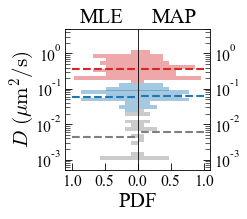

In [9]:
colors = ['tab:red', 'tab:blue', 'tab:grey', 'tab:grey']

gs = plt.GridSpec(1, 2, wspace = 0, width_ratios=[1, 1])
fig = plt.figure(figsize = (2.5, 2.5))

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey = ax1)

####--BGMM, MLE & MLE plot

AIC_MLE_ds = np.array(AIC_MLE_ds)
bgmm = BGMM(n_components = 4,
            max_iter = 50,
            n_init = 50,
            init_params = 'kmeans',
            random_state = 1,
            weight_concentration_prior = 20,
            mean_precision_prior = 0.5,
            covariance_type = 'spherical',
#            covariance_prior = 0.6,
            covariance_prior = 0.3,
            degrees_of_freedom_prior = 5).fit(np.log10(AIC_MLE_ds[:, None]))
bgmm_labels = bgmm.predict(np.log10(AIC_MLE_ds[:, None])) 
    
mu = bgmm.means_
var = bgmm.covariances_
weights = bgmm.weights_

hist, bins = np.histogram(np.log10(AIC_MLE_ds), density = True, bins = np.linspace(-3, 0.5, 35))
bins = (bins[:len(bins) - 1] + (bins[1] - bins[0]) / 2).copy()

for i in range(4):
    print(len(AIC_MLE_ds[bgmm_labels == i]))
    print('weight:', weights[i])
    print('mu:', 10**mu[i])
    print('var:', var[i])

for i in range(3):
    globals()['AICMLEbound{}'.format(i+1)] = np.min(AIC_MLE_ds[bgmm_labels == i])
    globals()['index{}'.format(i+1)] = np.where(globals()['AICMLEbound{}'.format(i+1)] <= 10 ** bins)[0][0]

ax1.barh(10**bins[index1:], hist[index1:], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index1:], color = colors[0], alpha = 0.4)
ax1.barh(10**bins[index2:index1], hist[index2:index1], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index2:index1], color = colors[1], alpha = 0.4)
ax1.barh(10**bins[index3:index2], hist[index3:index2], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index3:index2], color = colors[2], alpha = 0.4)
ax1.barh(10**bins[:index3], hist[:index3], height = (bins[1] - bins[0]) * 2.3 * 10**bins[:index3], color = colors[3], alpha = 0.4)

ax1.invert_xaxis()
ax1.set_yscale('log')
ax1.set_xlim(1.1, 0)
ax1.set_ylim(0.0005, 5)
ax1.set_xticks([1, 0.5])
ax1.set_title('MLE')

xspace2 = np.linspace(1, 0, 5)
for i in range(3):
    ax1.plot(xspace2, 10**mu[i] * np.ones(len(xspace2)), '--', linewidth = 2, color = colors[i])

####--BGMM, MLE & MLE plot


####-MAP plot

AIC_MAP_ds = np.array(AIC_MAP_ds)
bgmm = BGMM(n_components = 4,
            max_iter = 50,
            n_init = 50,
            init_params = 'kmeans',
            random_state = 1,
            weight_concentration_prior = 20,
            mean_precision_prior = 0.5,
            covariance_type = 'spherical',
#            covariance_prior = 0.6,
            covariance_prior = 0.3,
            degrees_of_freedom_prior = 5).fit(np.log10(AIC_MAP_ds[:, None]))
bgmm_labels = bgmm.predict(np.log10(AIC_MAP_ds[:, None])) 
    
mu = bgmm.means_
var = bgmm.covariances_
weights = bgmm.weights_
    
hist, bins = np.histogram(np.log10(AIC_MAP_ds), density = True, bins = np.linspace(-3, 0.5, 35))
bins = (bins[:len(bins) - 1] + (bins[1] - bins[0]) / 2).copy()

for i in range(4):
    print(len(AIC_MAP_ds[bgmm_labels == i]))
    print('weight:', weights[i])
    print('mu:', 10**mu[i])
    print('var:', var[i])

for i in range(3):
    globals()['AICMAPbound{}'.format(i+1)] = np.min(AIC_MAP_ds[bgmm_labels == i])
    globals()['index{}'.format(i+1)] = np.where(globals()['AICMAPbound{}'.format(i+1)] <= 10 ** bins)[0][0]

ax2.barh(10**bins[index1:], hist[index1:], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index1:], color = colors[0], alpha = 0.4)
ax2.barh(10**bins[index2:index1], hist[index2:index1], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index2:index1], color = colors[1], alpha = 0.4)
ax2.barh(10**bins[index3:index2], hist[index3:index2], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index3:index2], color = colors[2], alpha = 0.4)

#yspace = np.linspace(-3, 0.2, 1000)
#for i in range(len(mu)):
#    ax2.plot(weights[i].flatten() * norm.pdf(yspace, mu[i].flatten(), var[i].flatten()), 10 ** yspace)

ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.set_xlim(0, 1.1)
ax2.set_xticks([0, 0.5, 1])
ax2.set_title('MAP')
ax2.set_xlabel('PDF')
ax2.xaxis.set_label_coords(0, -0.15)
ax1.yaxis.set_label_coords(-0.4, 0.5)
ax1.set_ylabel(r'$D~(\mu \mathrm{m^2 / s})$')

for i in range(3):
    ax2.plot(xspace2, 10**mu[i] * np.ones(len(xspace2)), '--', linewidth = 2, color = colors[i])

plt.plot()
####-MAP plot

####--average transition matrix
P_avg = np.zeros((2, 2))
cnt = 0

paths = ['MSH2/5nM/results', 'MSH2/10nM/results']

for i, path in enumerate(paths):
    for j in range(fnum[i]):
        with open('{}/MAP{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
            temp = pickle.load(f)
            tempD, tempP = sample_sorting(temp, np.sqrt(len(temp)-1).astype(int))
            
ax1.tick_params(which = 'major', labelsize = 15, direction = 'in', length = 7, bottom = True)
ax1.tick_params(which = 'minor', direction = 'in', length = 5)
ax2.tick_params(which = 'major', labelsize = 15, direction = 'in', length = 7, bottom = True)
ax2.tick_params(which = 'minor', direction = 'in', length = 5)
               
               
ax1.set_yticks([0.001, 0.01, 0.1, 1])
ax2.set_yticks([0.001, 0.01, 0.1, 1])
               
               
ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))
ax2.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))
#ax2.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=5))

#plt.savefig('AIC_clustering.pdf', format = 'pdf', dpi = 1200)

### Bayesian

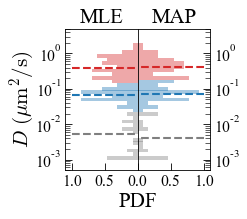

In [10]:
####--model histogram & plot setting

gs = plt.GridSpec(1, 2, wspace = 0, width_ratios=[1, 1])
fig = plt.figure(figsize = (2.5, 2.5))

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey = ax1)

####--model histogram & plot setting

####--BGMM, MLE & MLE plot

Bayes_MLE_ds = np.array(Bayes_MLE_ds)
bgmm = BGMM(n_components = 4,
            max_iter = 50,
            n_init = 20,
            init_params = 'kmeans',
            random_state = 1,
            weight_concentration_prior = 20,
            mean_precision_prior = 0.5,
            covariance_type = 'spherical',
            covariance_prior = 0.3,
            degrees_of_freedom_prior = 5).fit(np.log10(Bayes_MLE_ds[:, None]))
bgmm_labels = bgmm.predict(np.log10(Bayes_MLE_ds[:, None])) 
    
mu = bgmm.means_
var = bgmm.covariances_
weights = bgmm.weights_

hist, bins = np.histogram(np.log10(Bayes_MLE_ds), density = True, bins = np.linspace(-3, 0.5, 35))
bins = (bins[:len(bins) - 1] + (bins[1] - bins[0]) / 2).copy()

for i in range(3):
    globals()['bound{}'.format(i+1)] = np.min(Bayes_MLE_ds[bgmm_labels == i])
    globals()['bayesMLEbound{}'.format(i+1)] = np.min(Bayes_MLE_ds[bgmm_labels == i])
    globals()['index{}'.format(i+1)] = np.where(globals()['bound{}'.format(i+1)] <= 10 ** bins)[0][0]

ax1.barh(10**bins[index1:], hist[index1:], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index1:], color = colors[0], alpha = 0.4)
ax1.barh(10**bins[index2:index1], hist[index2:index1], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index2:index1], color = colors[1], alpha = 0.4)
ax1.barh(10**bins[index3:index2], hist[index3:index2], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index3:index2], color = colors[2], alpha = 0.4)
#ax1.barh(10**bins[:index3], hist[:index3], height = (bins[1] - bins[0]) * 2.3 * 10**bins[:index3], color = colors[3], alpha = 0.4)

ax1.invert_xaxis()
ax1.set_yscale('log')
ax1.set_xlim(1.1, 0)
ax1.set_ylim(0.0005, 5)
ax1.set_xticks([1, 0.5])
ax1.set_title('MLE')
ax1.tick_params(which = 'both', direction = 'in')

xspace2 = np.linspace(1, 0, 5)
for i in range(3):
    ax1.plot(xspace2, 10**mu[i] * np.ones(len(xspace2)), '--', linewidth = 2, color = colors[i])

####--BGMM, MLE & MLE plot

####-MAP plot

Bayes_MAP_ds = np.array(Bayes_MAP_ds)
bgmm = BGMM(n_components = 4,
            max_iter = 50,
            n_init = 20,
            init_params = 'kmeans',
            random_state = 1,
            weight_concentration_prior = 20,
            mean_precision_prior = 0.5,
            covariance_type = 'spherical',
            covariance_prior = 0.3,
            degrees_of_freedom_prior = 5).fit(np.log10(Bayes_MAP_ds[:, None]))
bgmm_labels = bgmm.predict(np.log10(Bayes_MAP_ds[:, None])) 
    
mu = bgmm.means_
var = bgmm.covariances_
weights = bgmm.weights_
    
hist, bins = np.histogram(np.log10(Bayes_MAP_ds), density = True, bins = np.linspace(-3, 0.5, 35))
bins = (bins[:len(bins) - 1] + (bins[1] - bins[0]) / 2).copy()

for i in range(3):
    globals()['bound{}'.format(i+1)] = np.min(Bayes_MAP_ds[bgmm_labels == i])
    globals()['bayesMAPbound{}'.format(i+1)] = np.min(Bayes_MAP_ds[bgmm_labels == i])
    globals()['index{}'.format(i+1)] = np.where(globals()['bound{}'.format(i+1)] <= 10 ** bins)[0][0]

ax2.barh(10**bins[index1:], hist[index1:], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index1:], color = colors[0], alpha = 0.4)
ax2.barh(10**bins[index2:index1], hist[index2:index1], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index2:index1], color = colors[1], alpha = 0.4)
ax2.barh(10**bins[index3:index2], hist[index3:index2], height = (bins[1] - bins[0]) * 2.3 * 10**bins[index3:index2], color = colors[2], alpha = 0.4)

#yspace = np.linspace(-3, 0.2, 1000)
#for i in range(len(mu)):
#    ax2.plot(weights[i].flatten() * norm.pdf(yspace, mu[i].flatten(), var[i].flatten()), 10 ** yspace)

ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.set_xlim(0, 1.1)
ax2.set_xticks([0, 0.5, 1])
ax2.set_title('MAP')
ax2.set_xlabel('PDF')
ax2.xaxis.set_label_coords(0, -0.15)
ax2.tick_params(which = 'both', direction = 'in')

ax1.yaxis.set_label_coords(-0.4, 0.5)
ax1.set_ylabel(r'$D~(\mu \mathrm{m^2 / s})$')

for i in range(3):
    ax2.plot(xspace2, 10**mu[i] * np.ones(len(xspace2)), '--', linewidth = 2, color = colors[i])

    
ax1.tick_params(which = 'major', labelsize = 15, direction = 'in', length = 7, bottom = True)
ax1.tick_params(which = 'minor', direction = 'in', length = 5)
ax2.tick_params(which = 'major', labelsize = 15, direction = 'in', length = 7, bottom = True)
ax2.tick_params(which = 'minor', direction = 'in', length = 5)
               
               
ax1.set_yticks([0.001, 0.01, 0.1, 1])
ax2.set_yticks([0.001, 0.01, 0.1, 1])
               
               
ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))
ax2.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))

plt.plot()

####--average transition matrix
P_avg = np.zeros((2, 2))
cnt = 0

paths = ['MSH2/5nM/results', 'MSH2/10nM/results']

for i, path in enumerate(paths):
    for j in range(fnum[i]):
        with open('{}/MAP{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
            temp = pickle.load(f)
            tempD, tempP = sample_sorting(temp, np.sqrt(len(temp)-1).astype(int))
            if len(tempD) == 2:
                if bound1 <= tempD[1] and bound2 <= tempD[0] < bound1:
                    P_avg += tempP
                    cnt += 1
P_avg /= cnt
#print(P_avg)

####--average transition matrix

#plt.savefig('Bayes_clustering_appendix.pdf', format = 'pdf', dpi = 1200)